In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from glob import glob
import math

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import os # used for navigating to image path
import imageio # used for writing images

import datetime

from PIL import Image
from PIL import ImageFile

##not sure why I need this but I do
ImageFile.LOAD_TRUNCATED_IMAGES = True


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


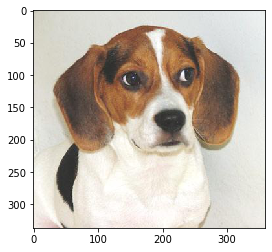

In [2]:
## Load the image
data = plt.imread('/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02088364-beagle/n02088364_4527.jpg')

# Display the image
plt.imshow(data)
plt.show()

In [3]:
file_paths = []
image_ids = []
breed_labels = []

directory_name = '/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/'

for directory in os.listdir(directory_name):
    if directory != '.DS_Store':
        for file in os.listdir(directory_name+str(directory)):
            file_paths.append(directory_name
                              +str(directory)+'/'+str(file))
            breed_labels.append(str(directory).split('-')[1])
            image_ids.append(file)

df = pd.DataFrame()

df['file_path'] = file_paths
df['image_id'] = image_ids
df['breed_label'] = breed_labels

df

,file_path,image_id,breed_label
0,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_26.jpg,silky_terrier
1,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_4869.jpg,silky_terrier
2,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_595.jpg,silky_terrier
3,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_9222.jpg,silky_terrier
4,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_422.jpg,silky_terrier
...,...,...,...
20575,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_237.jpg,black
20576,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_222.jpg,black
20577,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_1021.jpg,black
20578,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_183.jpg,black


In [4]:
#figuring out heights and widths of each image for better processing

list_of_heights = []
list_of_widths = []

for path in df['file_path']:
    image = load_img(path)
    np_array = img_to_array(image)
    list_of_heights.append(np_array.shape[0])
    list_of_widths.append(np_array.shape[1])

df.loc[:,('img_height')] = list_of_heights
df.loc[:,('img_width')] = list_of_widths

In [5]:
img_size = df[['img_height','img_width']]

img_size.describe()

,img_height,img_width
count,20580.000000,20580.000000
mean,385.861224,442.531876
std,124.863446,142.792308
min,100.000000,97.000000
25%,333.000000,361.000000
50%,375.000000,500.000000
75%,453.000000,500.000000
max,2562.000000,3264.000000


In [6]:
#binning a dataframe above by size for better visualization

img_size.loc[:,('img_height_bin')] = pd.cut(img_size['img_height'], list(range(0,4004, 100)))

img_size.loc[:,('img_width_bin')] = pd.cut(img_size['img_width'], list(range(0,4004, 100)))

img_size = img_size[img_size['img_height'] <= 2000]

img_size = img_size[img_size['img_width'] <= 2000]

heights = img_size.groupby('img_height_bin').count()[['img_height']].reset_index()
widths = img_size.groupby('img_width_bin').count()[['img_width']].reset_index()

heights.loc[:,('img_height_bin')] = heights['img_height_bin'].astype('str')
heigths2 = heights.rename(columns = {'img_height':'height_img_count'})

widths.loc[:,('img_width_bin')] = widths['img_width_bin'].astype('str')
widths2 = widths.rename(columns = {'img_width':'width_img_count'})

sizes_df = heigths2.merge(widths2, left_index = True, right_index = True).rename(columns = {'img_height_bin':'size'})\
           [['size','height_img_count','width_img_count']]

sizes_df.head(4)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,size,height_img_count,width_img_count
0,"(0, 100]",3,2
1,"(100, 200]",901,808
2,"(200, 300]",2233,1847
3,"(300, 400]",11395,4779


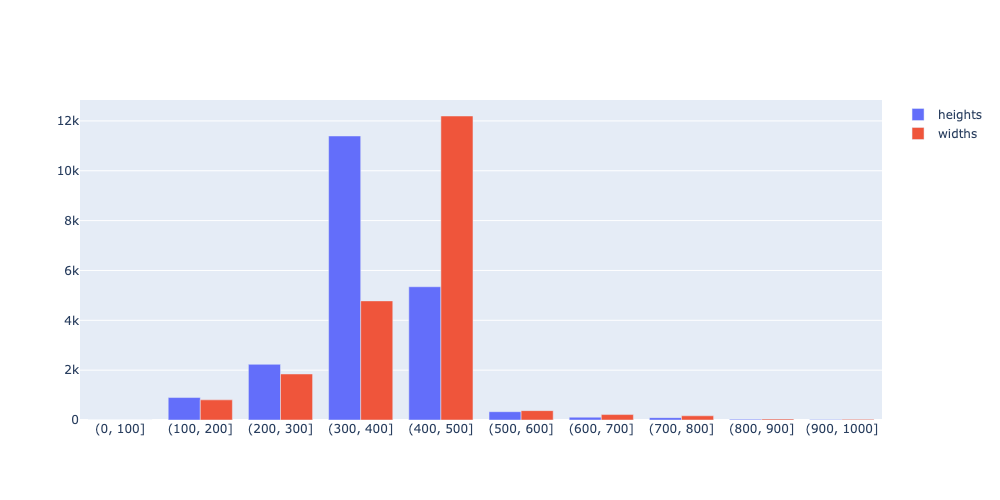

In [13]:
import plotly.graph_objects as go

sizes_mini_df = sizes_df.head(10)
sizes = sizes_df['size']

fig = go.Figure(data=[
    go.Bar(name='heights', x=sizes, y=sizes_mini_df['height_img_count']),
    go.Bar(name='widths', x=sizes, y=sizes_mini_df['width_img_count'])
])

# Change the bar mode
fig.update_layout(barmode='group')
#fig.update_layout(height = 500, width = 1000) #in case this is displayed in interactive mode
fig.show('png', height = 500, width = 1000)

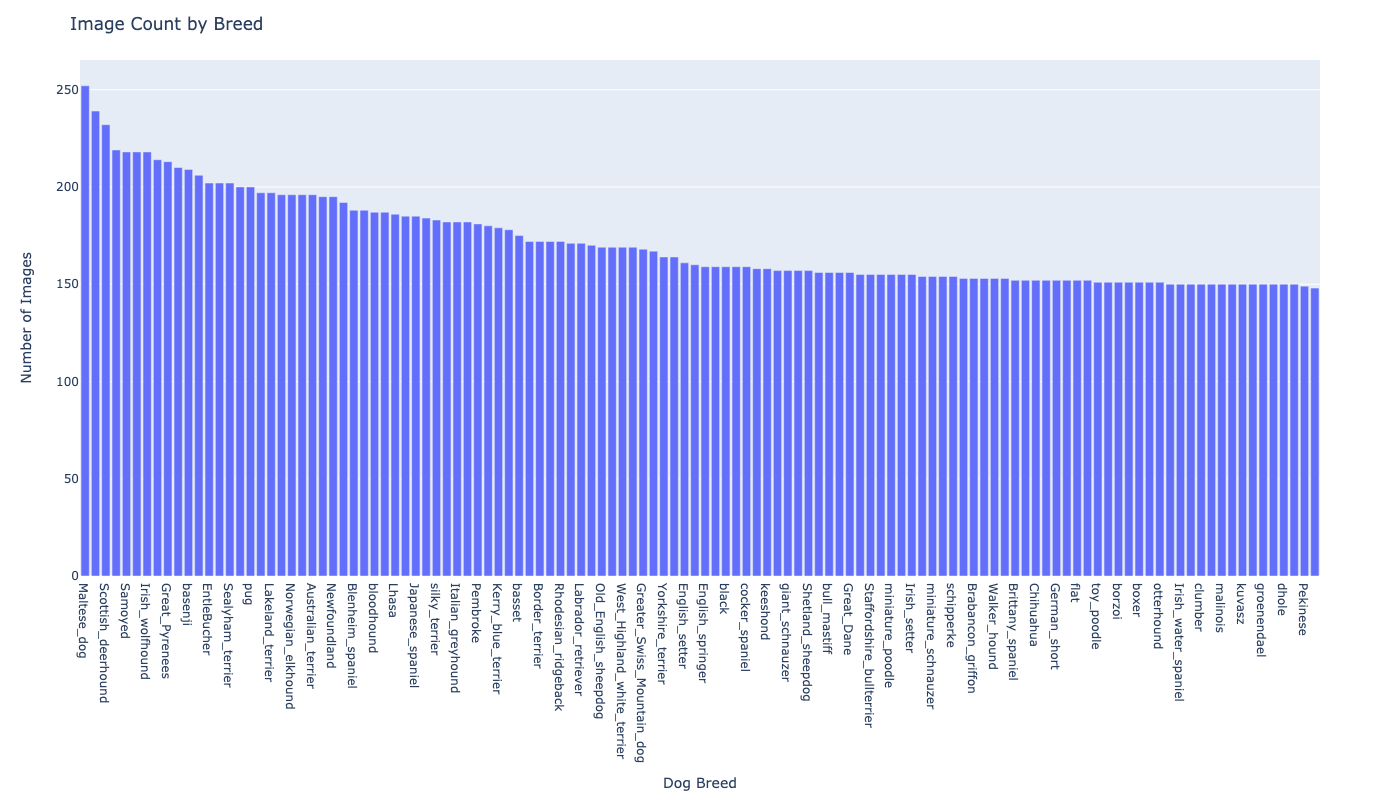

In [15]:
#we count the number of dog images per breed discovering the fact the the dataset in slightly imbalanced

breed_count_df = df.groupby('breed_label').count().reset_index()\
                .rename(columns = {'file_path':'dog_count'})[['breed_label','dog_count']]\
                .sort_values(by = 'dog_count', ascending = False)

fig = px.bar(breed_count_df, x='breed_label', y='dog_count')

fig.update_layout(title_text = 'Image Count by Breed',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Dog Breed')

#fig.update_layout(height = 1000, width = 1800)  #in case this is displayed in interactive mode

fig.show('png', height = 800, width = 1400)

In [28]:
df2 = df.merge(breed_count_df, left_on= 'breed_label', right_on = 'breed_label')
df3 = df2.sample(frac = 1)
df4 = df3[df3.dog_count > 160]
df5 = df4[['file_path','image_id','breed_label']]
df5

,file_path,image_id,breed_label
15501,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02088364_6211.jpg,beagle
6727,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02093859_1166.jpg,Kerry_blue_terrier
6335,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02085936_24464.jpg,Maltese_dog
7584,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02088238_9585.jpg,basset
16785,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02096437_1448.jpg,Dandie_Dinmont
...,...,...,...
5617,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02109525_13627.jpg,Saint_Bernard
15612,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02111889_1472.jpg,Samoyed
12547,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02091134_3685.jpg,whippet
8967,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02108000_306.jpg,EntleBucher


In [35]:
train_df = df5.iloc[0:round(len(df5)*0.8)]
test_df = df5.iloc[round(len(df5)*0.8):]

In [36]:
test_df.to_csv('/Users/ilya/Desktop/Computer-Science/U-Capstone/raw_data/test_df.csv')

In [37]:
def img_to_np_array(path):
    image = Image.open(path)
    image = image.resize((224,224))
    image = np.array(image)
    return image

In [44]:
test_data = []

for file_path, label in zip(test_df['file_path'], test_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    test_data.append([img_np_array, label])

test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

pd.get_dummies(test_labels).to_csv('/Users/ilya/Desktop/Computer-Science/U-Capstone/raw_data/test_column_names.csv')

test_images = test_images.reshape(-1, 224, 224, 3)
test_labels = pd.get_dummies(test_labels).to_numpy()

In [45]:
train_data = []

for file_path, label in zip(train_df['file_path'], train_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    train_data.append([img_np_array, label])

train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

train_images = train_images.reshape(-1, 224, 224, 3)
train_labels = pd.get_dummies(train_labels).to_numpy()

In [46]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(8981, 224, 224, 3)
(8981, 59)
(2245, 224, 224, 3)
(2245, 59)


In [48]:
directory = '/Users/ilya/Desktop/Computer-Science/U-Capstone/raw_data'

np.save(os.path.join(directory, 'train_images.npy'), train_images)
print("Train images saved!")

np.save(os.path.join(directory, 'train_labels.npy'), train_labels)
print("Train labels saved!")

np.save(os.path.join(directory, 'test_images.npy'), test_images)
print("Test images saved!")

np.save(os.path.join(directory, 'test_labels.npy'), test_labels)
print("Test labels saved!")

Train images saved!
Train labels saved!
Test images saved!
Test labels saved!
